In [1]:
import os
import json
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import tensorly as ts
from scipy import stats
from scipy.spatial import distance

In [2]:
# The manipulation and extraction procedures of the .json files obtained from Sonar output is copied from
# https://github.com/fga-eps-mds/Analytics, developed by Gabriel Filipe Manso in context of teacher assistant activities
# in EPS and MDS courses in 2020.2 academic period, under supervising by prof. Hilmer R. Neri in University of Brazilia,
# Faculty of Gama- Software Engineering graduate course.
# https://github.com/fga-eps-mds/A-Disciplina-MDS-EPS/blob/master/PlanosDeEnsino/EPS-cronograma-2020-2-hrn.md
# https://github.com/fga-eps-mds/A-Disciplina-MDS-EPS/blob/master/PlanosDeEnsino/MDS-cronograma-hrn.md
from scipy.stats import mannwhitneyu

%config InlineBackend.figure_format ='retina'

sns.set(font_scale=1.5)

sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
repos = ['Desenvolvimento']

language = [['Desenvolvimento', 'js']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]


In [5]:
jsons = glob('data/fga-eps-mds-2020-2-data/violeta/analytics-raw-data/*.json')

In [6]:
jsons

['data/fga-eps-mds-2020-2-data/violeta/analytics-raw-data/fga-eps-mds-2020.2-Violeta-Desenvolvimento-date_v1.11.0.json',
 'data/fga-eps-mds-2020-2-data/violeta/analytics-raw-data/fga-eps-mds-2020.2-Violeta-Desenvolvimento-date_v1.01.0.json',
 'data/fga-eps-mds-2020-2-data/violeta/analytics-raw-data/fga-eps-mds-2020.2-Violeta-Desenvolvimento-date_v1.10.2.json',
 'data/fga-eps-mds-2020-2-data/violeta/analytics-raw-data/fga-eps-mds-2020.2-Violeta-Desenvolvimento-date_v1.07.1.json',
 'data/fga-eps-mds-2020-2-data/violeta/analytics-raw-data/fga-eps-mds-2020.2-Violeta-Desenvolvimento-date_v1.09.0.json',
 'data/fga-eps-mds-2020-2-data/violeta/analytics-raw-data/fga-eps-mds-2020.2-Violeta-Desenvolvimento-date_v1.05.0.json',
 'data/fga-eps-mds-2020-2-data/violeta/analytics-raw-data/fga-eps-mds-2020.2-Violeta-Desenvolvimento-date_v2.00.0.json',
 'data/fga-eps-mds-2020-2-data/violeta/analytics-raw-data/fga-eps-mds-2020.2-Violeta-Desenvolvimento-date_v1.07.0.json',
 'data/fga-eps-mds-2020-2-data/v

In [7]:
def read_json(json_path):

    with open(json_path) as json_file:
        json_obj = json.load(json_file)

    return json_obj

In [8]:
def create_base_component_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)

    aux_df = df['filename'].str.split(r"fga-eps-mds-2020.2-Violeta-(.*?)-date_(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [9]:
base_component_df = create_base_component_df(jsons)

In [10]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
96,complexity,79,NaN,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
97,duplicated_lines_density,11.8,False,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
98,functions,54,NaN,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
99,ncloc,1523,NaN,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
100,reliability_rating,1.0,True,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
101,security_rating,1.0,True,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
102,comment_lines_density,18.1,False,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
103,files,69,NaN,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
8,complexity,79,NaN,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.01.0
9,duplicated_lines_density,11.8,False,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.01.0


In [11]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [12]:
def metric_per_file(json):

    file_json = []

    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)

    return file_json

In [13]:
def generate_file_dataframe(metric_list, json, language_extension):

    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)

    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass

    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [14]:
def generate_file_dataframe_per_release(metric_list, json, language_extension):

    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)

    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass

    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [15]:
def create_file_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        file_component_data = metric_per_file(file_component)
        file_name = os.path.basename(i)

        file_repository = file_name.split("-")[5]
        file_language = repos_language[f"{file_repository}"]

        file_component_df = generate_file_dataframe_per_release(metric_list,
                                                                file_component_data,
                                                                language_extension = file_language)
        file_component_df['filename'] = file_name

        df = df.append(file_component_df, ignore_index=True)

    # replace TeamName by yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020.2-Violeta-(.*?)-date_(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [16]:
file_component_df = create_file_df(jsons)

In [17]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
224,frontend/src/App.js,1,1,0.0,0.0,NaN,19,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
225,frontend/src/App.test.js,1,1,0.0,0.0,NaN,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
226,frontend/src/components/footer.js,1,1,0.0,0.0,NaN,57,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
227,frontend/src/components/header.js,3,5,0.0,0.0,NaN,44,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
228,frontend/src/components/home.js,1,1,0.0,0.0,NaN,21,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
229,frontend/src/index.js,0,0,30.0,0.0,NaN,7,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
230,frontend/src/components/questionario.js,5,5,2.9,0.0,NaN,99,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
231,frontend/src/serviceWorker.js,15,32,19.1,0.0,NaN,93,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
26,frontend/src/App.js,1,1,0.0,0.0,NaN,19,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.01.0
27,frontend/src/App.test.js,1,1,0.0,0.0,NaN,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.01.0


In [18]:
# Create dataframe per repository

repository_dataframes = {}

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df

repository_dataframes.keys()

dict_keys(['Desenvolvimento'])

In [19]:
# Defining measure em1 calculation, where em1 = density of non-complex file
def em1(df):
    m0 = np.median(df['complexity'].astype(float)/df['functions'].astype(float))
    m1 = df['complexity'].astype(float)
    m2 = df['functions'].astype(float)
    m3 = len(df) # total files

    #  intervals for em1 thresholds
    x = np.array([0, m0])
    y = np.array([1, 0])

    # Defining intervals for em1 interpretation(numeric interpolation). It indicates quality score
    IF1 = np.interp(list(((m1/m2) <= m0)[(m2 > 0)]),x, y)

    em1 = sum(IF1)/m3

    return em1

In [20]:
def em2(df):

    # Defining metrics for measure em2, where em2 = density of commented files
    m3 = len(df) # total files
    m4 = df['comment_lines_density'].astype(float)

    #  intervals for em1 thresholds
    x = np.array([0.1, 0.3])
    y = np.array([1, 0])

    # Defining intervals for em2 interpretation(numeric interpolation). It indicates quality score
    em2i = []
    for if2i in m4:
        if 10 <= if2i <= 30:
            em2i.append(np.interp(if2i/100,x, y))
        else:
            em2i.append(0)

    em2 = np.sum(em2i)/m3

    return em2

In [21]:
def em3(df):

    # Defining metrics for measure em3,where ma3 = absence of duplication on file (density)
    m3 = len(df) # total files
    m5 = df['duplicated_lines_density'].astype(float)

    #  intervals for em1 thresholds
    x = np.array([0, 0.05])
    y = np.array([1, 0])

    # Intervals for ma3 interpretation
    em3i = []
    for if3i in m5:
        if  if3i < 5:
            em3i.append(np.interp(if3i/100,x, y))
        else:
            em3i.append(0)

    em3 = np.sum(em3i)/m3

    return em3

In [22]:
def create_metrics_df(df):

    version_vec = df['version'].unique()

    em1_list = []
    em2_list = []
    em3_list = []
    repository_list = []
    version_list = []

    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        em1_list.append(em1(version_df))
        em2_list.append(em2(version_df))
        em3_list.append(em3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    metrics_df = pd.DataFrame({'em1': em1_list,
                               'em2': em2_list,
                               'em3': em3_list,
                               'repository': repository_list,
                               'version': version_list})

    return metrics_df

In [23]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df

In [24]:
repository_dataframes["Desenvolvimento"].head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
224,frontend/src/App.js,1,1,0.0,0.0,NaN,19,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
225,frontend/src/App.test.js,1,1,0.0,0.0,NaN,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
226,frontend/src/components/footer.js,1,1,0.0,0.0,NaN,57,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
227,frontend/src/components/header.js,3,5,0.0,0.0,NaN,44,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
228,frontend/src/components/home.js,1,1,0.0,0.0,NaN,21,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
229,frontend/src/index.js,0,0,30.0,0.0,NaN,7,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
230,frontend/src/components/questionario.js,5,5,2.9,0.0,NaN,99,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
231,frontend/src/serviceWorker.js,15,32,19.1,0.0,NaN,93,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.00.0
26,frontend/src/App.js,1,1,0.0,0.0,NaN,19,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.01.0
27,frontend/src/App.test.js,1,1,0.0,0.0,NaN,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020.2-Violeta-Desenvolvimento-dat...,Desenvolvimento,v1.01.0


In [25]:
repository_metrics["Desenvolvimento"]

,em1,em2,em3,repository,version
0,0.875000,0.068125,1.000000,Desenvolvimento,v1.00.0
1,0.875000,0.068125,1.000000,Desenvolvimento,v1.01.0
2,0.900000,0.054500,1.000000,Desenvolvimento,v1.04.0
3,0.900000,0.054500,1.000000,Desenvolvimento,v1.05.0
4,0.900000,0.054500,1.000000,Desenvolvimento,v1.06.0
5,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.0
6,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.1
7,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.2
8,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.3
9,0.818182,0.058864,1.000000,Desenvolvimento,v1.08.0


In [26]:
repos_metrics_list = []

repos_metrics_list.append(repository_metrics["Desenvolvimento"])

In [27]:
#Printing Desenvolvimento_metrics

repos_metrics_list[0]

,em1,em2,em3,repository,version
0,0.875000,0.068125,1.000000,Desenvolvimento,v1.00.0
1,0.875000,0.068125,1.000000,Desenvolvimento,v1.01.0
2,0.900000,0.054500,1.000000,Desenvolvimento,v1.04.0
3,0.900000,0.054500,1.000000,Desenvolvimento,v1.05.0
4,0.900000,0.054500,1.000000,Desenvolvimento,v1.06.0
5,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.0
6,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.1
7,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.2
8,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.3
9,0.818182,0.058864,1.000000,Desenvolvimento,v1.08.0


## Plotting em1, em2 and em3 in Desenvolvimento repository

### em1

(0.7, 0.95)

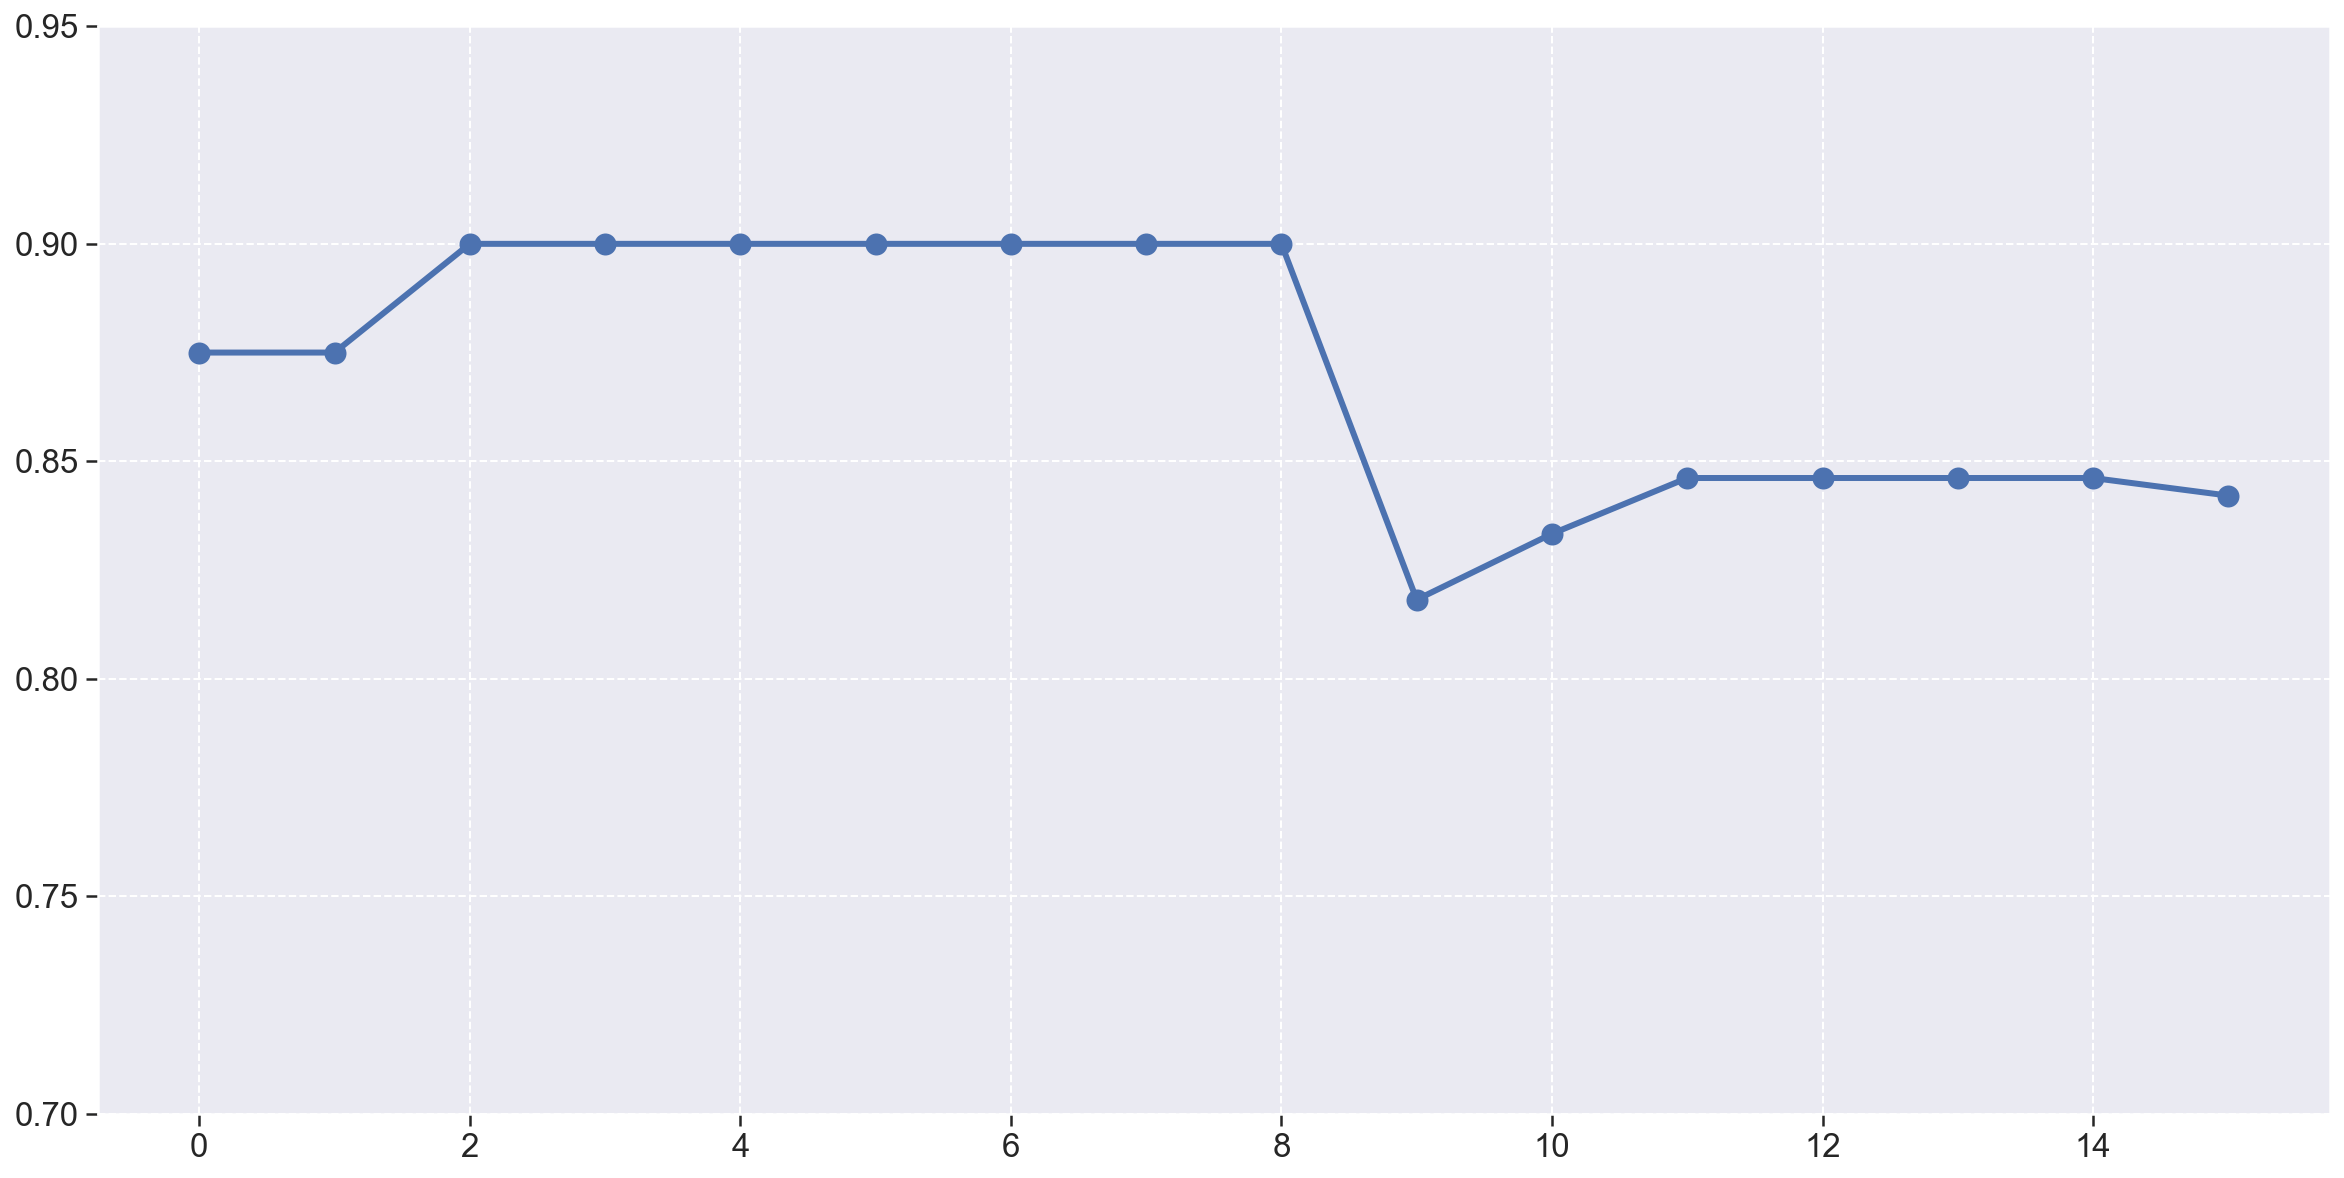

In [59]:
fig = plt.figure(figsize=(20, 10))

# Background color
plt.axhspan(-.001,.016, color="#c9f9ff", alpha=0.3)

plt.plot(repos_metrics_list[0]['em1'], linewidth=3, marker='o', markersize=10)

plt.ylim(.7,.95)

### em2

(-0.001, 0.2)

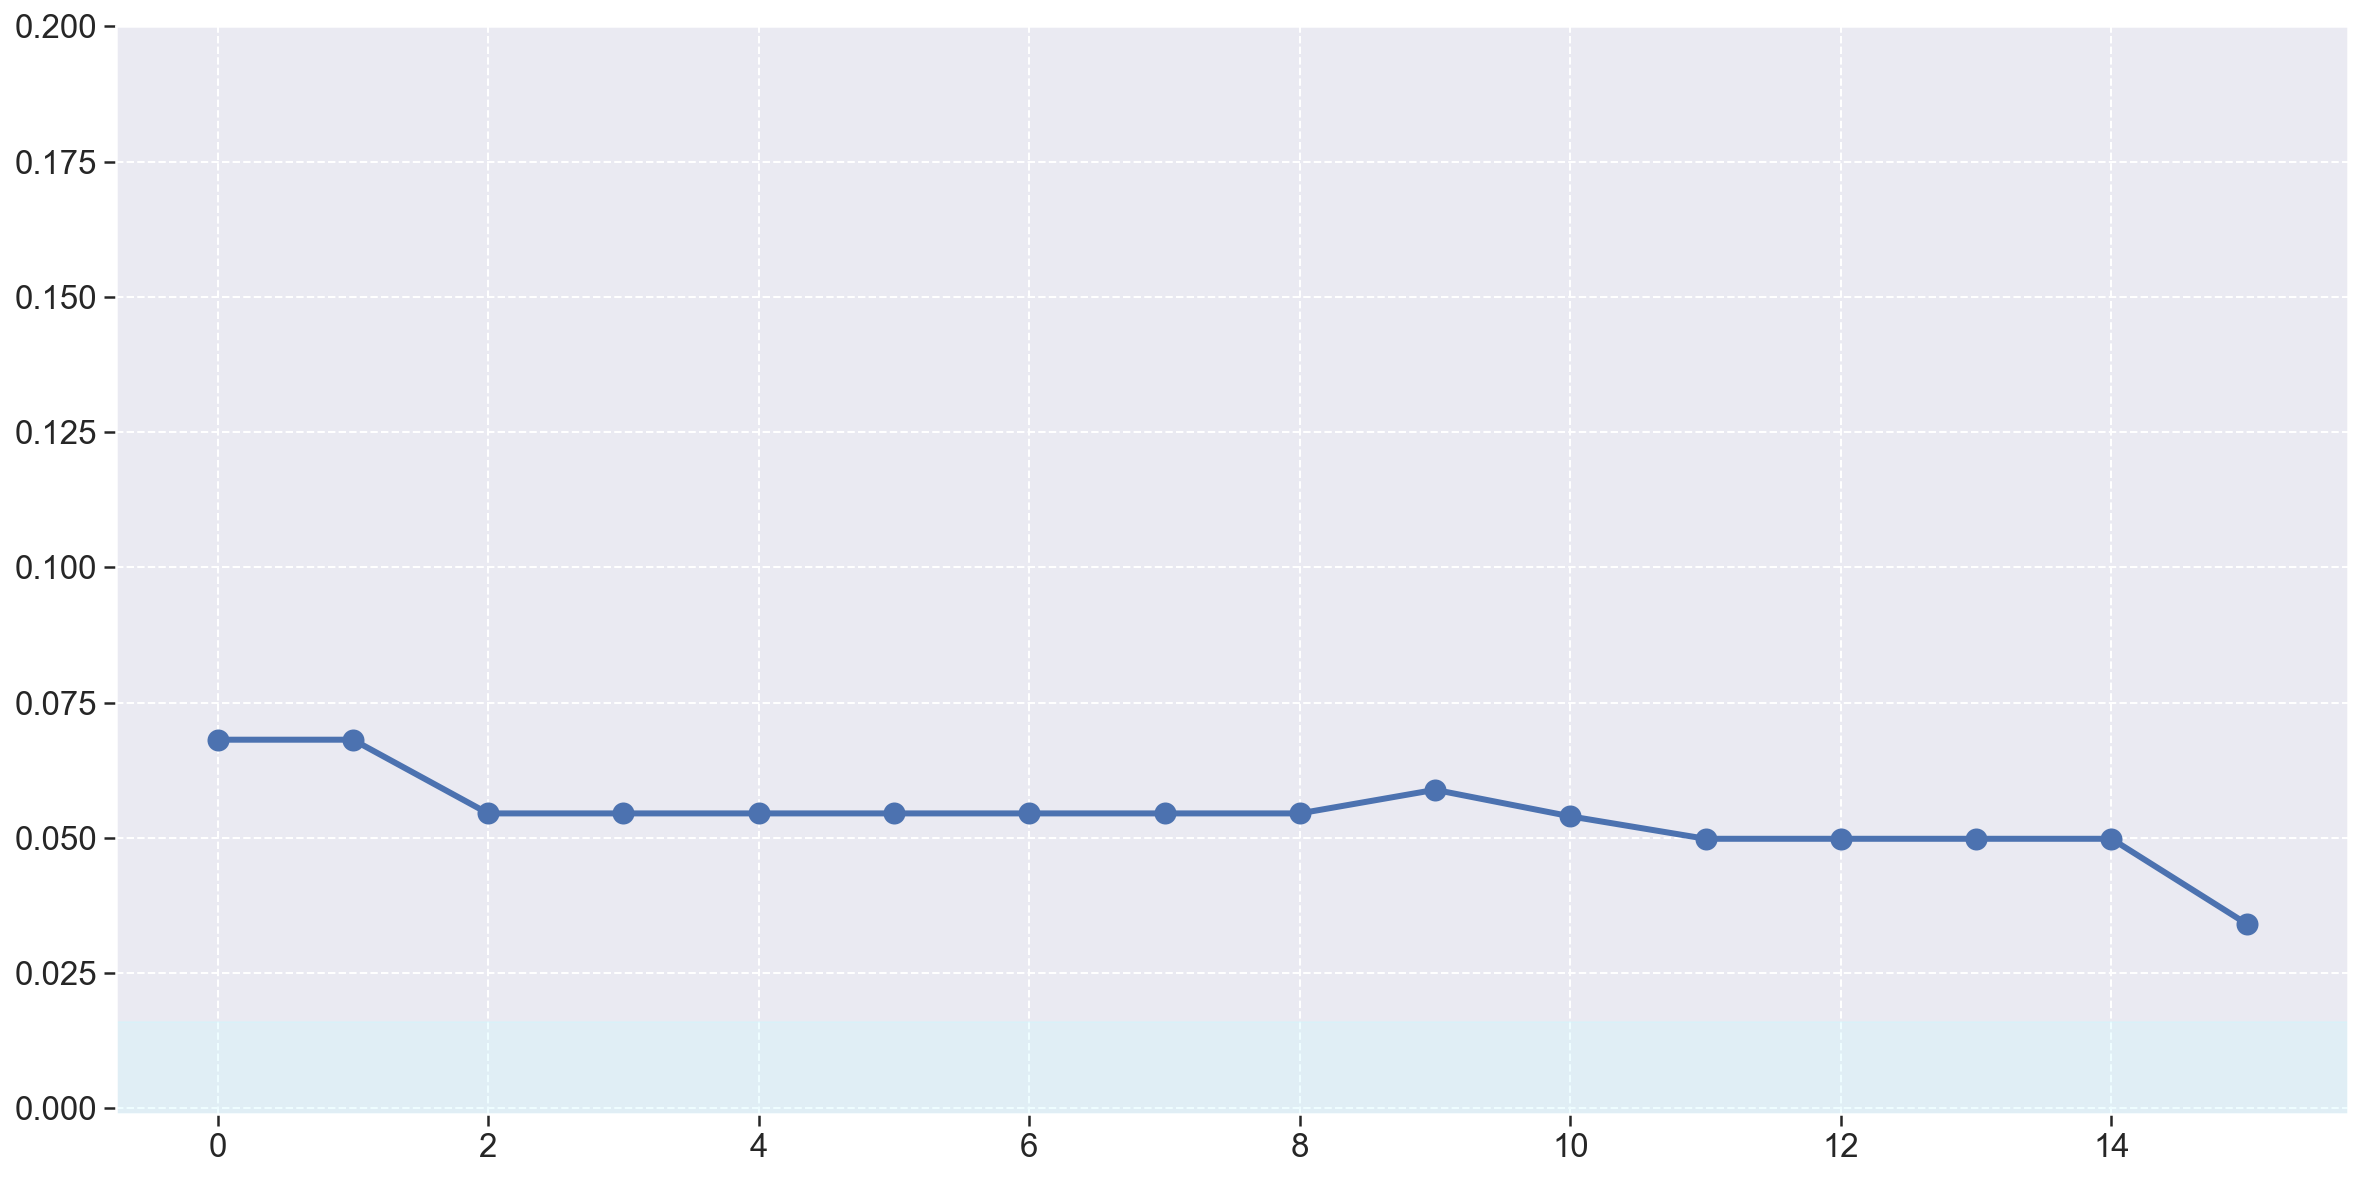

In [29]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['em2'], linewidth=3, marker='o', markersize=10)


# Background color
plt.axhspan(-.001,.016, color="#c9f9ff", alpha=0.3)

plt.ylim(-.001,.2)

### em3

(0.75, 1.01)

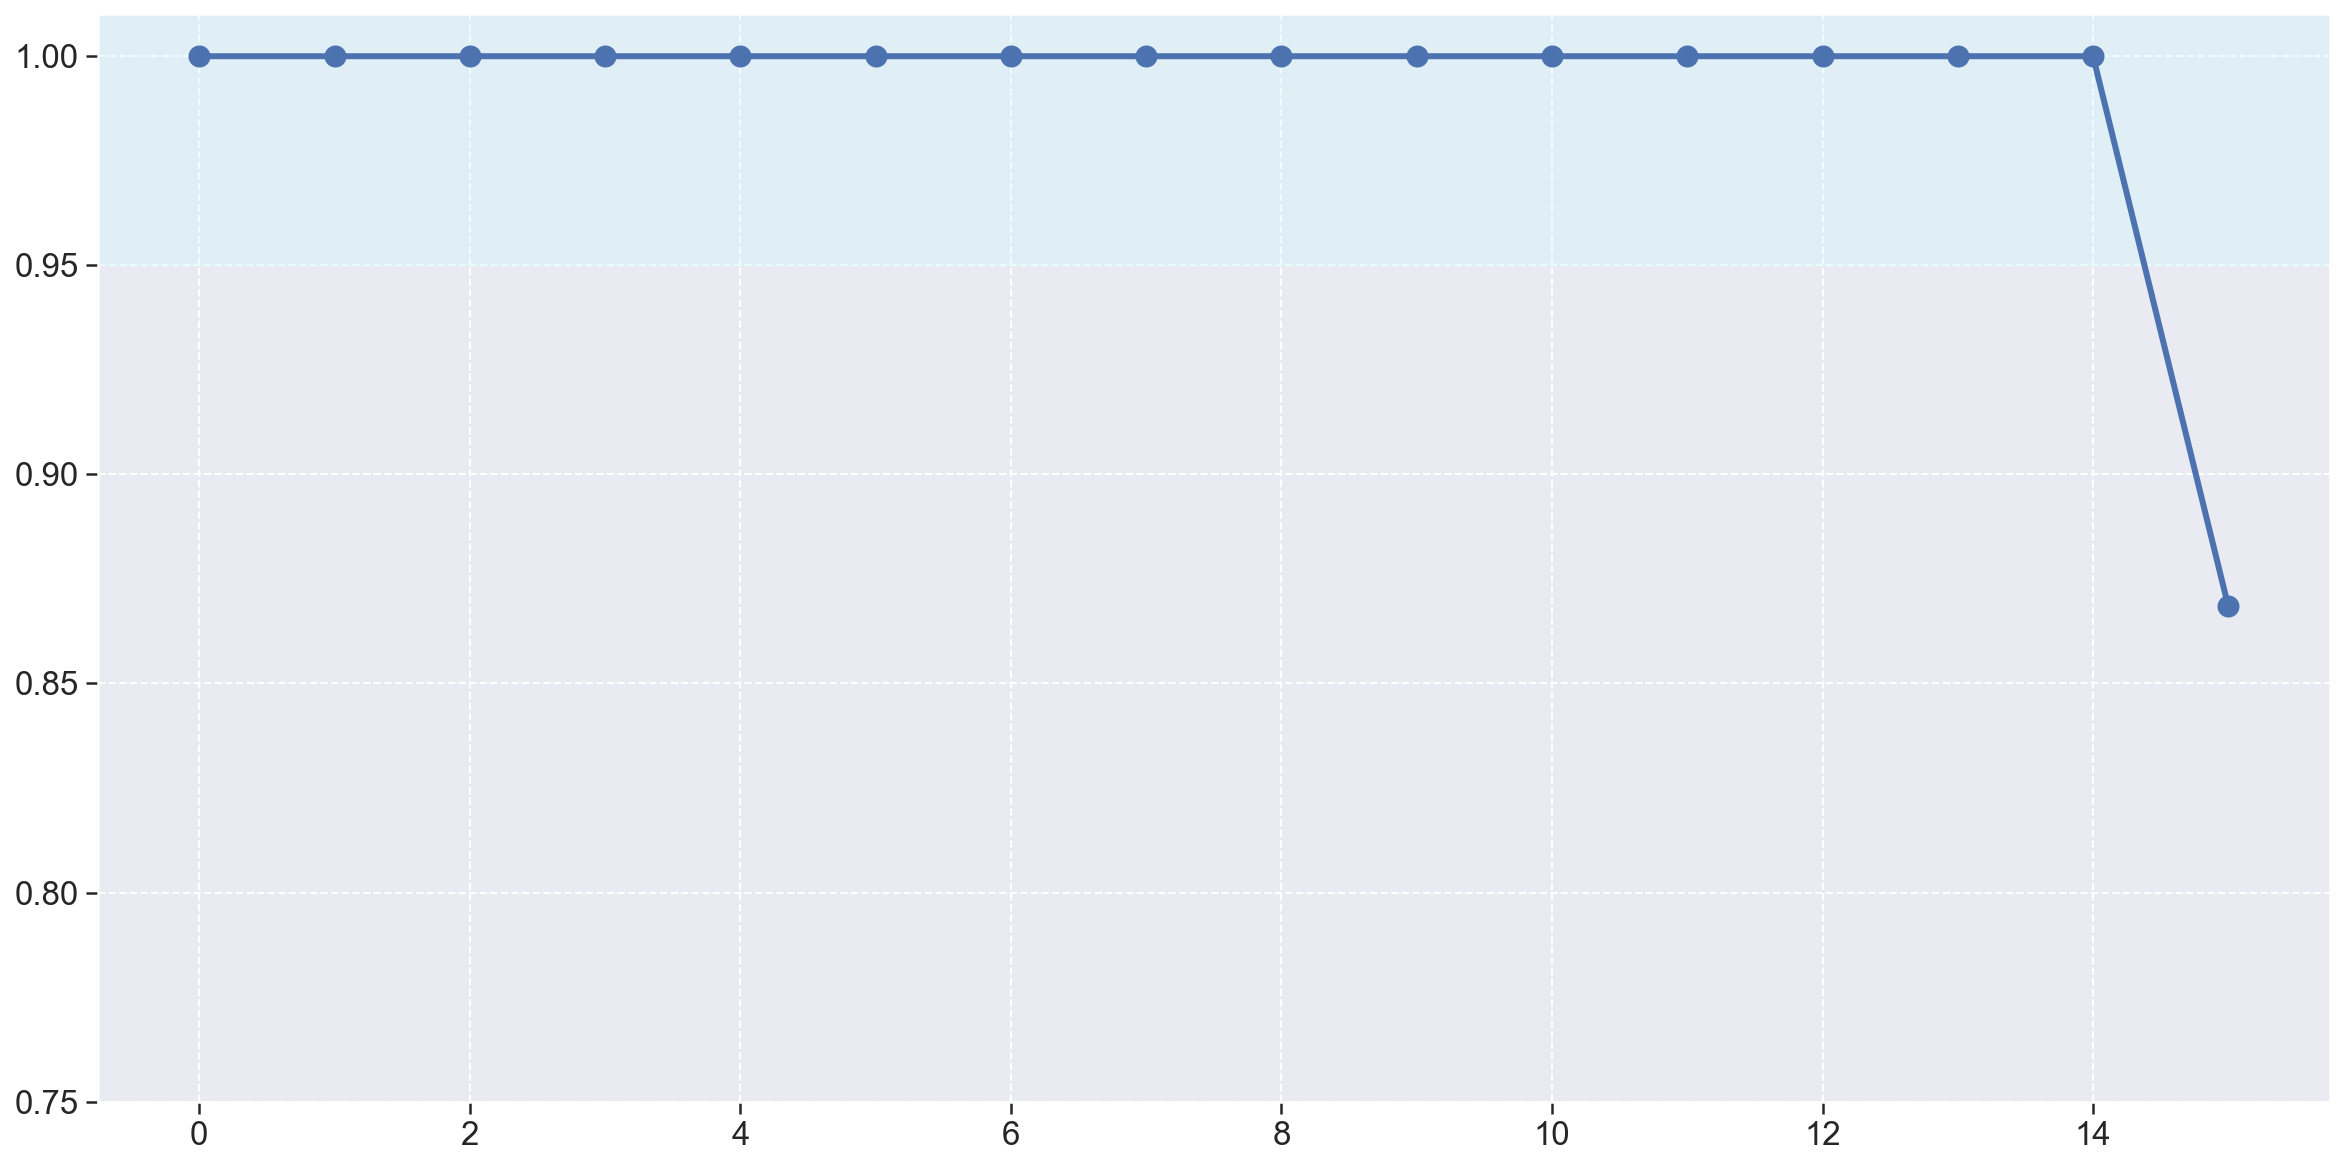

In [30]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['em3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.95,1.01, color="#c9f9ff", alpha=0.3)

plt.ylim(.75,1.01)

### All metrics

(-0.02, 1.02)

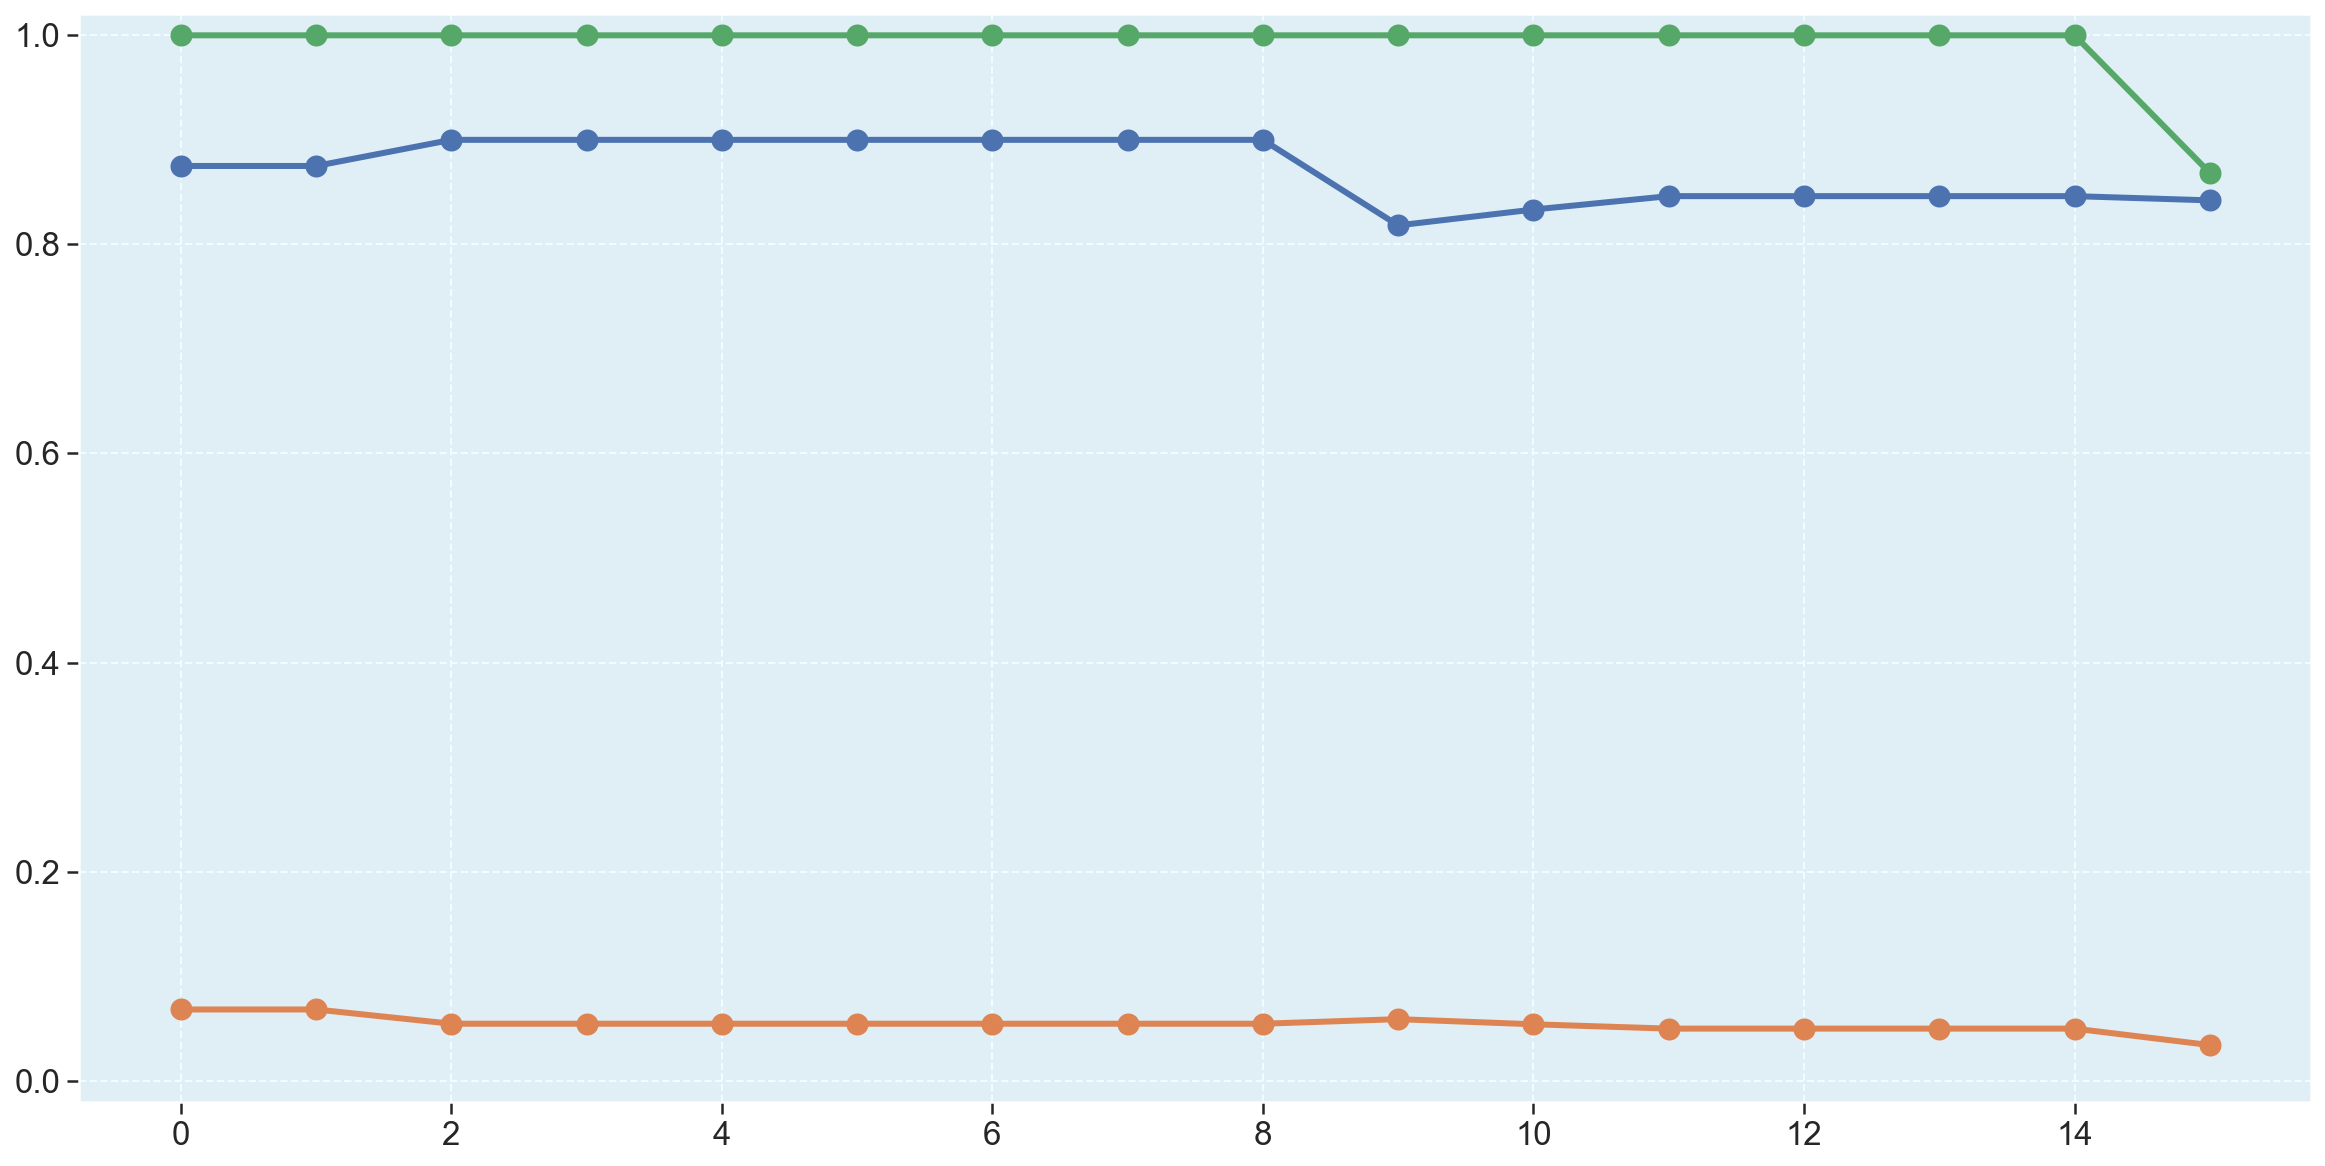

In [31]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['em1'], linewidth=3, marker='o', markersize=10)
plt.plot(repos_metrics_list[0]['em2'], linewidth=3, marker='o', markersize=10)
plt.plot(repos_metrics_list[0]['em3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

### Setting measures weighs

In [32]:
# wem1 = 33%
# wem2 = 33%
# wem3 = 33%

wem1=wem2=wem3 = 0.3374
SC_Modifiability_EM_Weights = np.array([wem1, wem2, wem3])

## Defining Modifiability quality sub-characteristic tensors per microservice.

In [33]:
def create_sc_tensor(measures_list, size_z):

    tensor_sc_measures = ts.tensor(measures_list).reshape((measures_list.shape[0],measures_list.shape[1],size_z))

    return tensor_sc_measures

repos_sc_measures_list = []

for repo_measures in repos_metrics_list:
    repos_sc_measures_list.append(np.array([repo_measures['em1'].astype(float),
                                            repo_measures['em2'].astype(float),
                                            repo_measures['em3'].astype(float)]))

t_sc_modifiability_tensor_list = []

t_sc_modifiability_tensor_list.append(create_sc_tensor(repos_sc_measures_list[0], 1))

print("Modifiability Tensor dimensions = " + str(t_sc_modifiability_tensor_list[0].ndim))

t_sc_modifiability_tensor_list[0]

Modifiability Tensor dimensions = 3


array([[[0.875     ],
        [0.875     ],
        [0.9       ],
        [0.9       ],
        [0.9       ],
        [0.9       ],
        [0.9       ],
        [0.9       ],
        [0.9       ],
        [0.81818182],
        [0.83333333],
        [0.84615385],
        [0.84615385],
        [0.84615385],
        [0.84615385],
        [0.84210526]],

       [[0.068125  ],
        [0.068125  ],
        [0.0545    ],
        [0.0545    ],
        [0.0545    ],
        [0.0545    ],
        [0.0545    ],
        [0.0545    ],
        [0.0545    ],
        [0.05886364],
        [0.05395833],
        [0.04980769],
        [0.04980769],
        [0.04980769],
        [0.04980769],
        [0.03407895]],

       [[1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
      

# Weighting tensor of the Modifiability Sub-Characteristic at measure level.

In [34]:
t_sc_modifiability_weighted_list = []

for i in range(len(t_sc_modifiability_tensor_list)):

    t_sc_modifiability_weighted = np.empty(t_sc_modifiability_tensor_list[i].shape)

    for j in range(t_sc_modifiability_tensor_list[i].ndim):
        t_sc_modifiability_weighted[:, :, 0][j] = np.tensordot(t_sc_modifiability_tensor_list[i][:,:,0][j],
                                                               SC_Modifiability_EM_Weights[j], 0)
    t_sc_modifiability_weighted_list.append(t_sc_modifiability_weighted)

t_sc_modifiability_weighted_list[0]


array([[[0.295225  ],
        [0.295225  ],
        [0.30366   ],
        [0.30366   ],
        [0.30366   ],
        [0.30366   ],
        [0.30366   ],
        [0.30366   ],
        [0.30366   ],
        [0.27605455],
        [0.28116667],
        [0.28549231],
        [0.28549231],
        [0.28549231],
        [0.28549231],
        [0.28412632]],

       [[0.02298537],
        [0.02298537],
        [0.0183883 ],
        [0.0183883 ],
        [0.0183883 ],
        [0.0183883 ],
        [0.0183883 ],
        [0.0183883 ],
        [0.0183883 ],
        [0.01986059],
        [0.01820554],
        [0.01680512],
        [0.01680512],
        [0.01680512],
        [0.01680512],
        [0.01149824]],

       [[0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3374    ],
      

# Aggregating and weighting SC_Modifiability quality characteristic tensor

In [35]:
wsc1 = 1

t_sc_modifiability_agregated_list = []

for i in range(len(t_sc_modifiability_weighted_list)):

    t_sc_modifiability_agregated = np.empty([t_sc_modifiability_weighted_list[i].shape[1]])

    for j in range(t_sc_modifiability_weighted_list[i].shape[1]):
        t_sc_modifiability_agregated[j] = np.linalg.norm(t_sc_modifiability_weighted_list[i][:,:,0][:,j])

    t_sc_modifiability_agregated_list.append(np.tensordot(t_sc_modifiability_agregated, wsc1, 0))

t_sc_modifiability_agregated_list[0]

array([0.44891523, 0.44891523, 0.45429757, 0.45429757, 0.45429757,
       0.45429757, 0.45429757, 0.45429757, 0.45429757, 0.43639353,
       0.43957354, 0.44229744, 0.44229744, 0.44229744, 0.44229744,
       0.40830388])

# Agregating and Weighting Maintainability quality characteristic tensor

In [36]:
wc1 = 1

t_c_maintainability_agregated_list = []

for i in range(len(t_sc_modifiability_agregated_list)):

    t_c_maintainability_agregated = np.empty([t_sc_modifiability_agregated_list[i].shape[0]])

    for j in range(t_sc_modifiability_agregated_list[i].shape[0]):
        t_c_maintainability_agregated[j] = np.linalg.norm(t_sc_modifiability_weighted_list[i][:,:,0][:,j])

    t_c_maintainability_agregated_list.append(np.tensordot(t_c_maintainability_agregated, wc1, 0))

t_c_maintainability_agregated_list[0]


array([0.44891523, 0.44891523, 0.45429757, 0.45429757, 0.45429757,
       0.45429757, 0.45429757, 0.45429757, 0.45429757, 0.43639353,
       0.43957354, 0.44229744, 0.44229744, 0.44229744, 0.44229744,
       0.40830388])

# Comparison of the product quality of two Releases. This comparison is obtained from cosine similarity between tensors.

In [37]:
SQC_1 = t_c_maintainability_agregated_list[0][0] # first_release from Desenvolvimento repository
SQC_2 = t_c_maintainability_agregated_list[0][15] # last_release from Desenvolvimento repository

distance.cosine(SQC_1, SQC_2)

0.0

# Intensity of difference between releases comparison

In [38]:
intensity_difference = SQC_2 - SQC_1

intensity_difference

-0.04061135658638443

In [39]:
for i in range(len(repos_metrics_list)):
    repos_metrics_list[i]['Modifiability'] = t_c_maintainability_agregated_list[i].tolist()
    repos_metrics_list[i]['Maintainability'] = t_c_maintainability_agregated_list[i].tolist()
    repos_metrics_list[i]['SQC'] = t_c_maintainability_agregated_list[i].tolist()


column_names = ["em1", "em2", "em3", "repository", "version", "Modifiability", "Maintainability", "SQC" ]

repos_metrics_list[0]

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.875000,0.068125,1.000000,Desenvolvimento,v1.00.0,0.448915,0.448915,0.448915
1,0.875000,0.068125,1.000000,Desenvolvimento,v1.01.0,0.448915,0.448915,0.448915
2,0.900000,0.054500,1.000000,Desenvolvimento,v1.04.0,0.454298,0.454298,0.454298
3,0.900000,0.054500,1.000000,Desenvolvimento,v1.05.0,0.454298,0.454298,0.454298
4,0.900000,0.054500,1.000000,Desenvolvimento,v1.06.0,0.454298,0.454298,0.454298
5,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.0,0.454298,0.454298,0.454298
6,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.1,0.454298,0.454298,0.454298
7,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.2,0.454298,0.454298,0.454298
8,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.3,0.454298,0.454298,0.454298
9,0.818182,0.058864,1.000000,Desenvolvimento,v1.08.0,0.436394,0.436394,0.436394


# Plotting the total quality(SQC) from VIOLETA Desenvolvimento microservice

(0.4, 0.5)

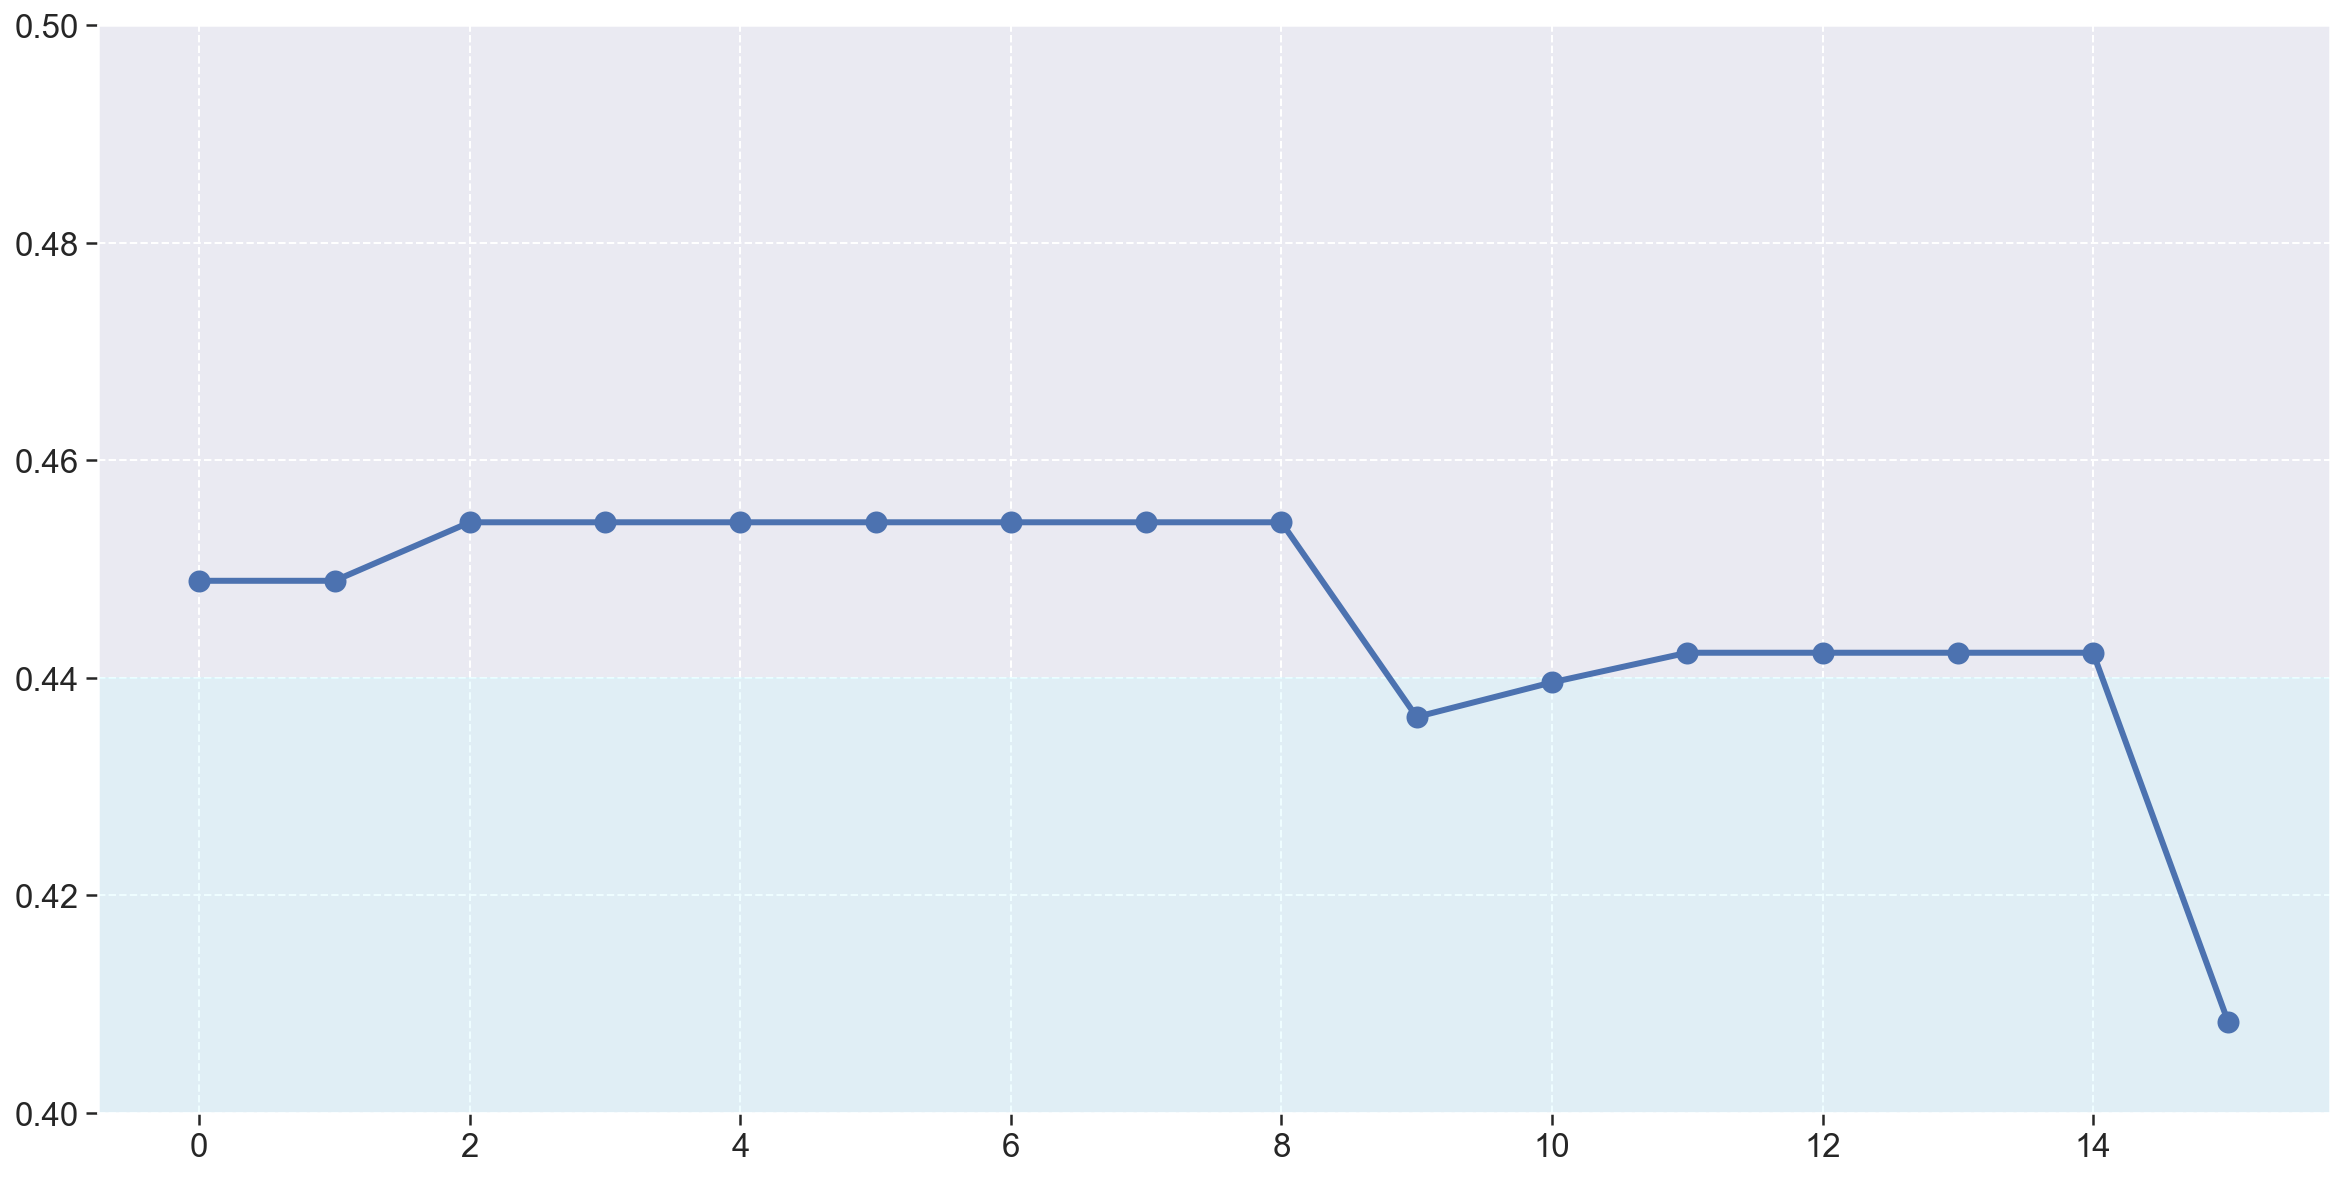

In [40]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repository_metrics["Desenvolvimento"]['SQC'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.32,.44, color="#c9f9ff", alpha=0.3)

plt.ylim(.4,.5)

# Plotting the total quality(SQC) from all VIOLETA microservices

(0.3, 0.5)

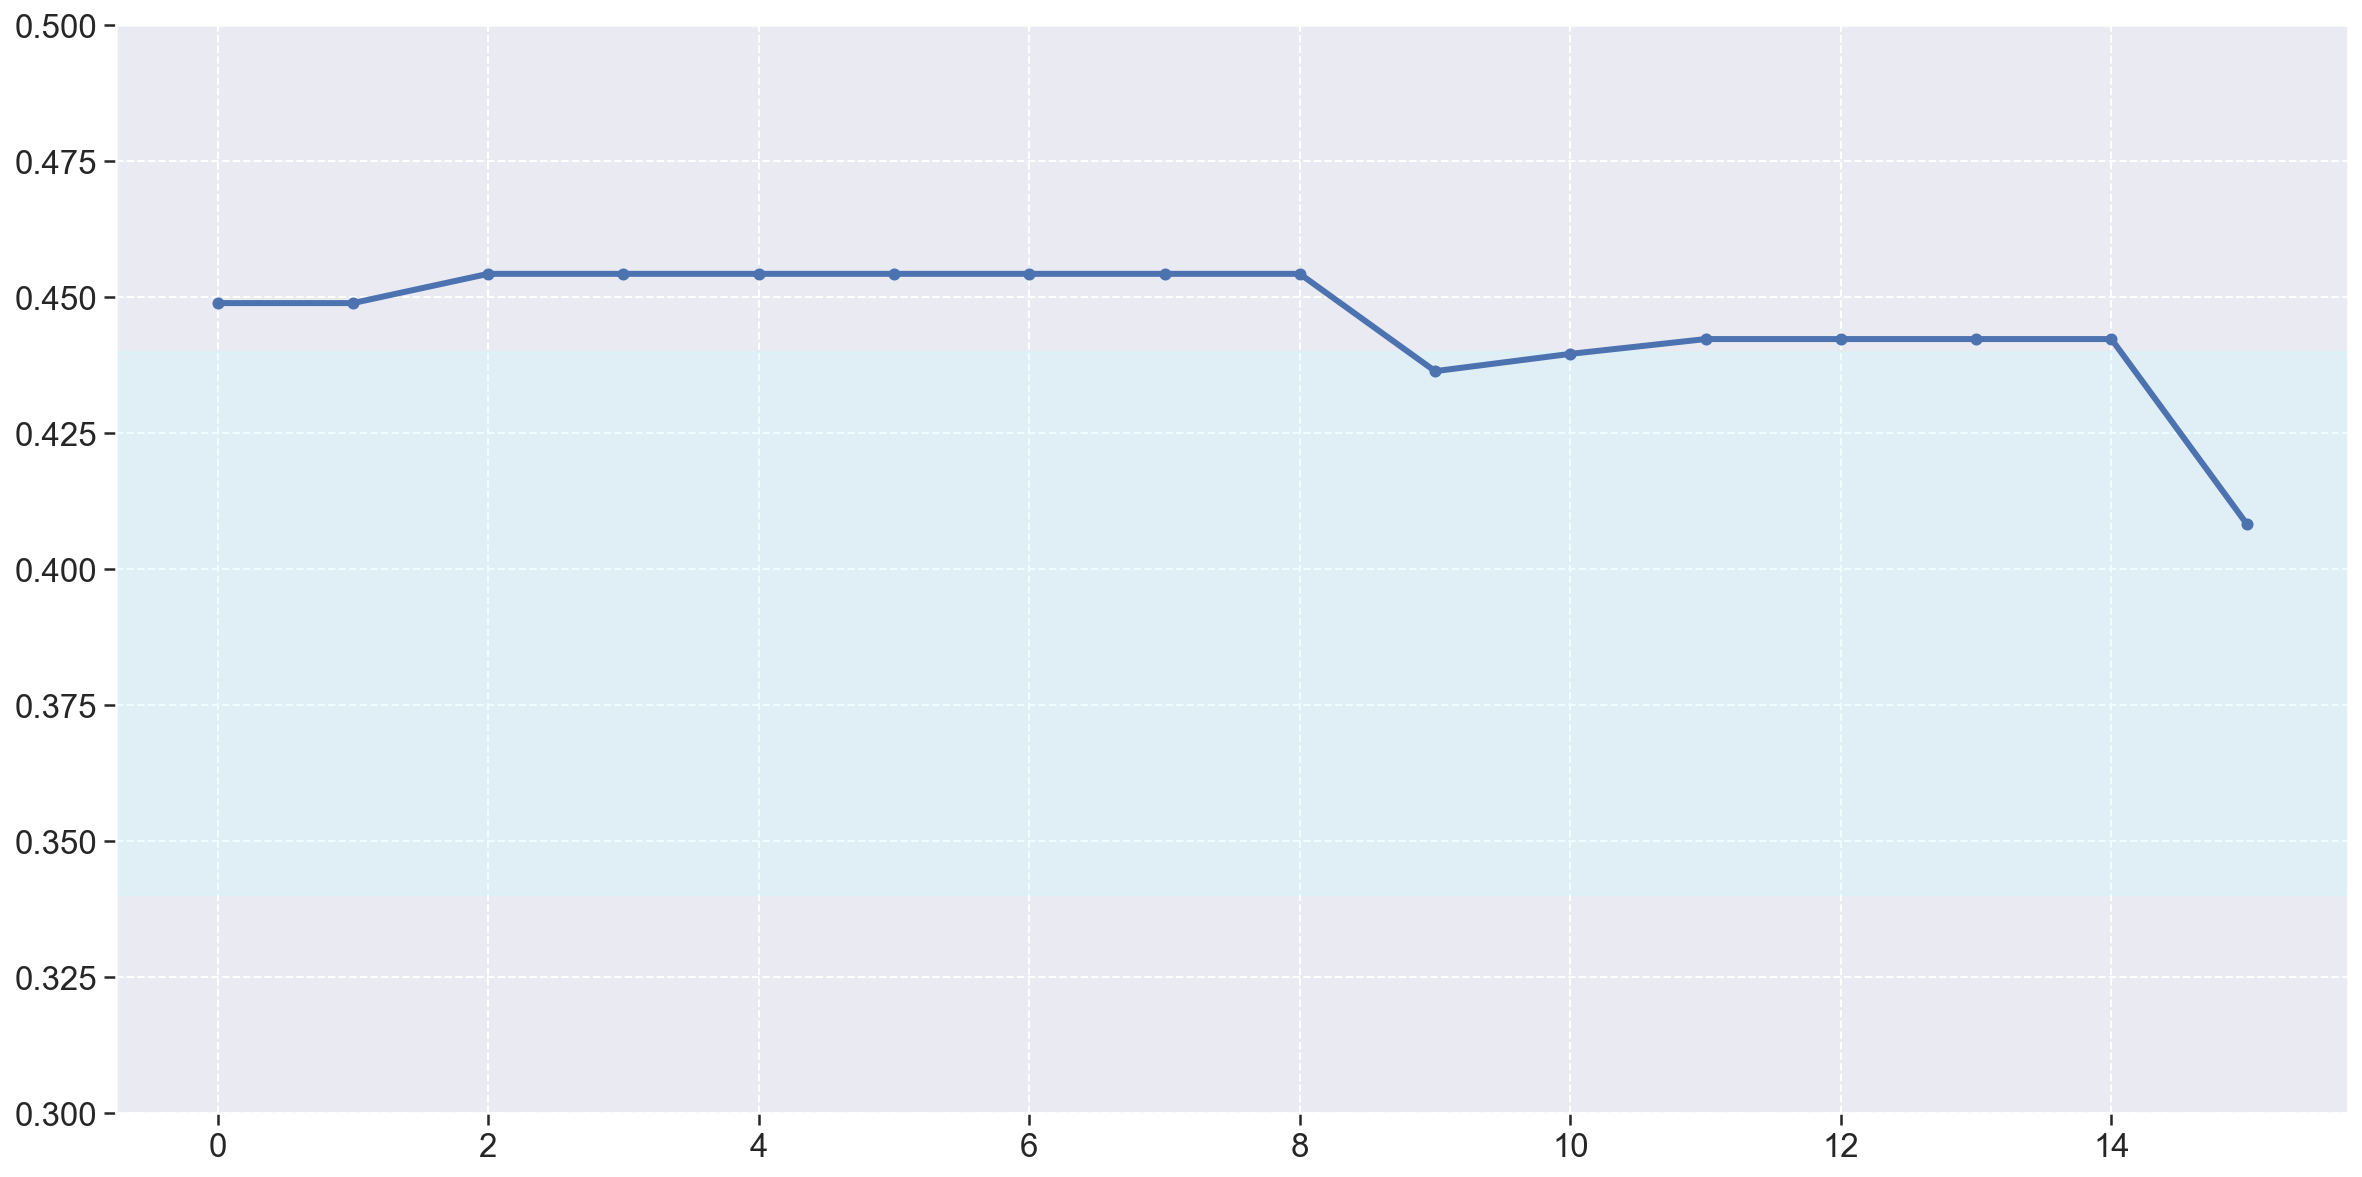

In [41]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['SQC'], linewidth=3, marker='o', markersize=5)

# Background color
plt.axhspan(.34,.44, color="#c9f9ff", alpha=0.3)

plt.ylim(.3,.5)

# Plotting the dataset with MeasureSoftGram's calculations

In [42]:
metrics_df = pd.concat([repository_metrics["Desenvolvimento"]], ignore_index=True)

metrics_df

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.875000,0.068125,1.000000,Desenvolvimento,v1.00.0,0.448915,0.448915,0.448915
1,0.875000,0.068125,1.000000,Desenvolvimento,v1.01.0,0.448915,0.448915,0.448915
2,0.900000,0.054500,1.000000,Desenvolvimento,v1.04.0,0.454298,0.454298,0.454298
3,0.900000,0.054500,1.000000,Desenvolvimento,v1.05.0,0.454298,0.454298,0.454298
4,0.900000,0.054500,1.000000,Desenvolvimento,v1.06.0,0.454298,0.454298,0.454298
5,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.0,0.454298,0.454298,0.454298
6,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.1,0.454298,0.454298,0.454298
7,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.2,0.454298,0.454298,0.454298
8,0.900000,0.054500,1.000000,Desenvolvimento,v1.07.3,0.454298,0.454298,0.454298
9,0.818182,0.058864,1.000000,Desenvolvimento,v1.08.0,0.436394,0.436394,0.436394


# Generating dataset in .CSV format

In [43]:
metrics_df.to_excel('data/fga-eps-mds-2020-2-data/violeta/measuresoftgram-violeta-dataset-23-03-2021-24-05-2021-excel.xlsx', header=False, index = False)
metrics_df.to_csv('data/fga-eps-mds-2020-2-data/violeta/measuresoftgram-violeta-dataset-23-03-2021-24-05-2021-csv.csv', header=False, index = False)
#metrics_df.to_json('data/metrics_df_json.json', index = False)


# Reading MeasureSoftGram and Q-Rapids dataset .CSV

In [44]:
qrapids_df = pd.read_csv('data/fga-eps-mds-2020-2-data/violeta/qrapids-violeta-dataset-23-03-2021-24-05-2021-csv.csv', sep=',', header=None,
                              names=['m1', 'm2', 'm3', 'repository', 'version', 'asc1', 'ac1','total'], dtype='a')

qrapids_df

,m1,m2,m3,repository,version,asc1,ac1,total
0,0.875,0.125,1.0,Desenvolvimento,v1.00.0,0.66,0.66,0.66
1,0.875,0.125,1.0,Desenvolvimento,v1.01.0,0.66,0.66,0.66
2,0.9,0.1,1.0,Desenvolvimento,v1.04.0,0.6600000000000001,0.6600000000000001,0.6600000000000001
3,0.9,0.1,1.0,Desenvolvimento,v1.05.0,0.6600000000000001,0.6600000000000001,0.6600000000000001
4,0.9,0.1,1.0,Desenvolvimento,v1.06.0,0.6600000000000001,0.6600000000000001,0.6600000000000001
5,0.9,0.1,1.0,Desenvolvimento,v1.07.0,0.6600000000000001,0.6600000000000001,0.6600000000000001
6,0.9,0.1,1.0,Desenvolvimento,v1.07.1,0.6600000000000001,0.6600000000000001,0.6600000000000001
7,0.9,0.1,1.0,Desenvolvimento,v1.07.2,0.6600000000000001,0.6600000000000001,0.6600000000000001
8,0.9,0.1,1.0,Desenvolvimento,v1.07.3,0.6600000000000001,0.6600000000000001,0.6600000000000001
9,0.8181818181818182,0.09090909090909091,1.0,Desenvolvimento,v1.08.0,0.6300000000000001,0.6300000000000001,0.6300000000000001


In [45]:
measuresoftgram_df = pd.read_csv('data/fga-eps-mds-2020-2-data/violeta/measuresoftgram-violeta-dataset-23-03-2021-24-05-2021-csv.csv', sep=',',
                                 header=None, names=column_names, dtype='a')

measuresoftgram_df

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.875,0.068125,1.0,Desenvolvimento,v1.00.0,0.44891523485942264,0.44891523485942264,0.44891523485942264
1,0.875,0.068125,1.0,Desenvolvimento,v1.01.0,0.44891523485942264,0.44891523485942264,0.44891523485942264
2,0.9,0.05450000000000001,1.0,Desenvolvimento,v1.04.0,0.4542975733777256,0.4542975733777256,0.4542975733777256
3,0.9,0.05450000000000001,1.0,Desenvolvimento,v1.05.0,0.4542975733777256,0.4542975733777256,0.4542975733777256
4,0.9,0.05450000000000001,1.0,Desenvolvimento,v1.06.0,0.4542975733777256,0.4542975733777256,0.4542975733777256
5,0.9,0.05450000000000001,1.0,Desenvolvimento,v1.07.0,0.4542975733777256,0.4542975733777256,0.4542975733777256
6,0.9,0.05450000000000001,1.0,Desenvolvimento,v1.07.1,0.4542975733777256,0.4542975733777256,0.4542975733777256
7,0.9,0.05450000000000001,1.0,Desenvolvimento,v1.07.2,0.4542975733777256,0.4542975733777256,0.4542975733777256
8,0.9,0.05450000000000001,1.0,Desenvolvimento,v1.07.3,0.4542975733777256,0.4542975733777256,0.4542975733777256
9,0.8181818181818182,0.05886363636363636,1.0,Desenvolvimento,v1.08.0,0.4363935324192763,0.4363935324192763,0.4363935324192763


# Statics Treatments

In [46]:
def is_normal(dist, alpha):

    k2, normal_Test_Pval = stats.normaltest(dist, axis=None)

    if (normal_Test_Pval > alpha): # alpha value is 0.05 or 5%
        return False

    return True

In [47]:
# alpha value is 0.05 or 5%
alpha = np.float64(0.05)

dist_control = qrapids_df["total"].to_numpy('float')
dist_predict = measuresoftgram_df["SQC"].to_numpy('float')


# Descriptive Statistics

In [48]:
print('Descriptive Statitics from Q-Rapids: '+ str(stats.describe(dist_control)))
print('Min: ' + str(dist_control.min(axis=0)))
print('Max: ' + str(dist_control.max(axis=0)))
print('Mean: '+ str(dist_control.mean(axis=0)))
print('Median: '+ str(np.median(dist_control, axis=0)))
print('Std: ' + str(dist_control.std(axis=0)))
print('Variance: ' + str(dist_control.var(axis=0)) + '\n')

print('Descriptive Statitics from MeasuresotGram: '+ str(stats.describe(dist_predict)))
print('Min: ' + str(dist_predict.min(axis=0)))
print('Max: ' + str(dist_predict.max(axis=0)))
print('Mean: '+ str(dist_predict.mean(axis=0)))
print('Median: '+ str(np.median(dist_predict, axis=0)))
print('Std: ' + str(dist_predict.std(axis=0)))
print('Variance: ' + str(dist_predict.var(axis=0)))

Descriptive Statitics from Q-Rapids: DescribeResult(nobs=16, minmax=(0.5818421052631579, 0.6600000000000001), mean=0.6451752277327936, variance=0.00045506928921347826, skewness=-1.6664316060929445, kurtosis=2.718090781731341)
Min: 0.5818421052631579
Max: 0.6600000000000001
Mean: 0.6451752277327936
Median: 0.66
Std: 0.020654962082696637
Variance: 0.00042662745863763585

Descriptive Statitics from MeasuresotGram: DescribeResult(nobs=16, minmax=(0.4083038782730382, 0.4542975733777256), mean=0.44571088825992533, variance=0.00014046831740406853, skewness=-2.028369181998316, kurtosis=4.228691269474518)
Min: 0.4083038782730382
Max: 0.4542975733777256
Mean: 0.44571088825992533
Median: 0.44891523485942264
Std: 0.011475584846373375
Variance: 0.00013168904756631424


#  Normality Test

In [49]:
print('*** Testing Normality - D’Agostino ****')
if is_normal(dist_predict, alpha):
    print("MeasuresftGram has  a normal distribution")
else:
    print("MeasuresftGram has not a normal distribution")

if is_normal(dist_control, alpha):
    print("Q-Rapids has a normal distribution")
else:
    print("Q-Rapids has not a normal distribution")

*** Testing Normality - D’Agostino ****
MeasuresftGram has  a normal distribution
Q-Rapids has a normal distribution


/usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Histogram

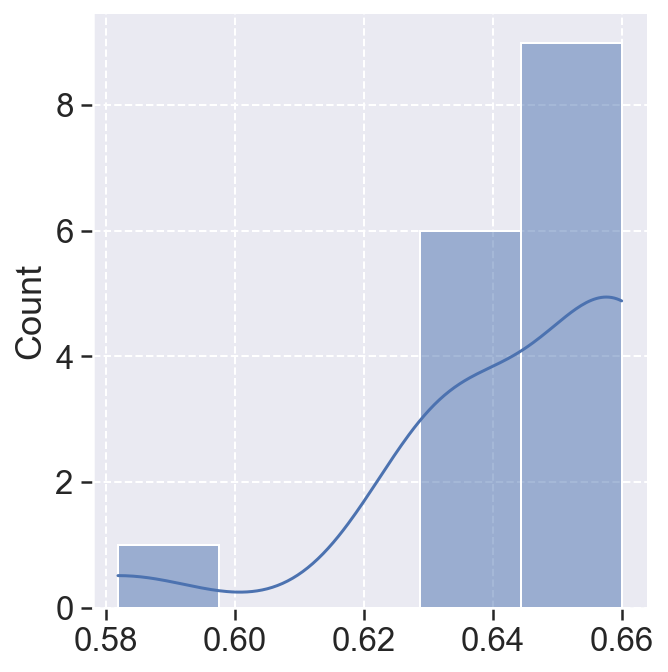

In [50]:
sns.displot(data=dist_control, kde=True)

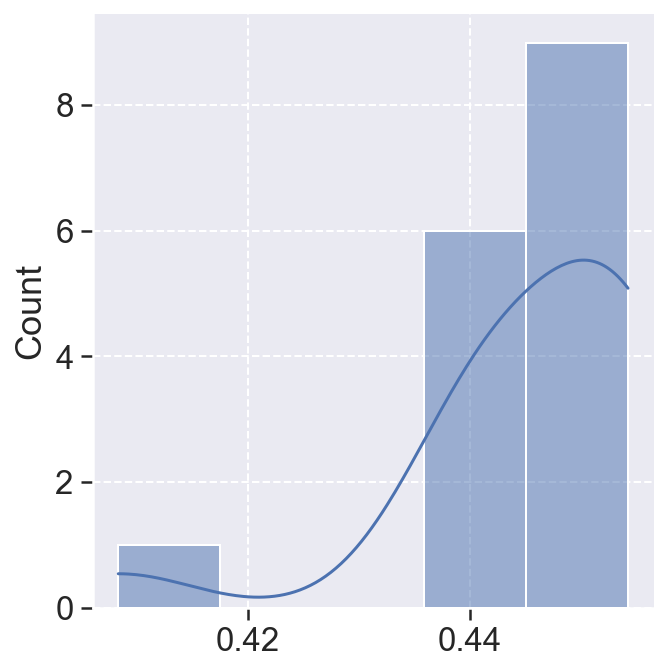

In [51]:
sns.displot(data=dist_predict, kde=True)

<Figure size 2160x1440 with 0 Axes>

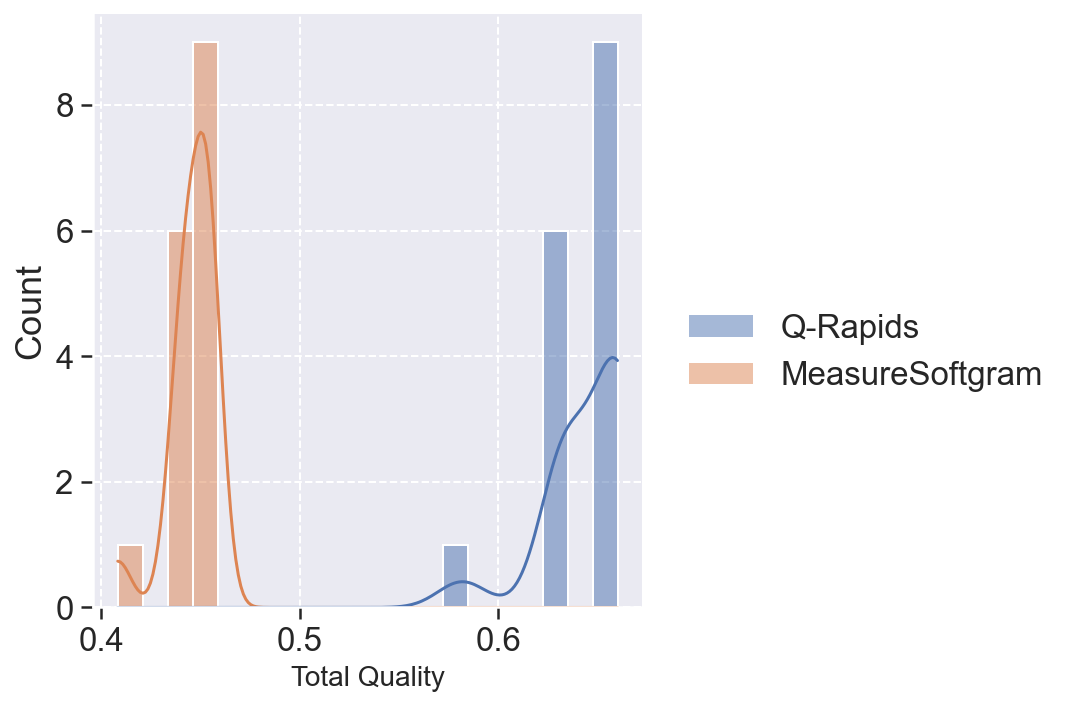

In [52]:
a = pd.DataFrame({'Q-Rapids' : qrapids_df.iloc[:,7].astype(float)})
b = pd.DataFrame({ 'MeasureSoftgram' : measuresoftgram_df.iloc[:,7].astype(float)})


df = a.append(b)

fig = plt.figure(figsize=(30, 20))

sns.displot(df, bins=20, kde=True)

plt.xlabel('Total Quality', fontsize=14)

plt.show()

# Boxplot

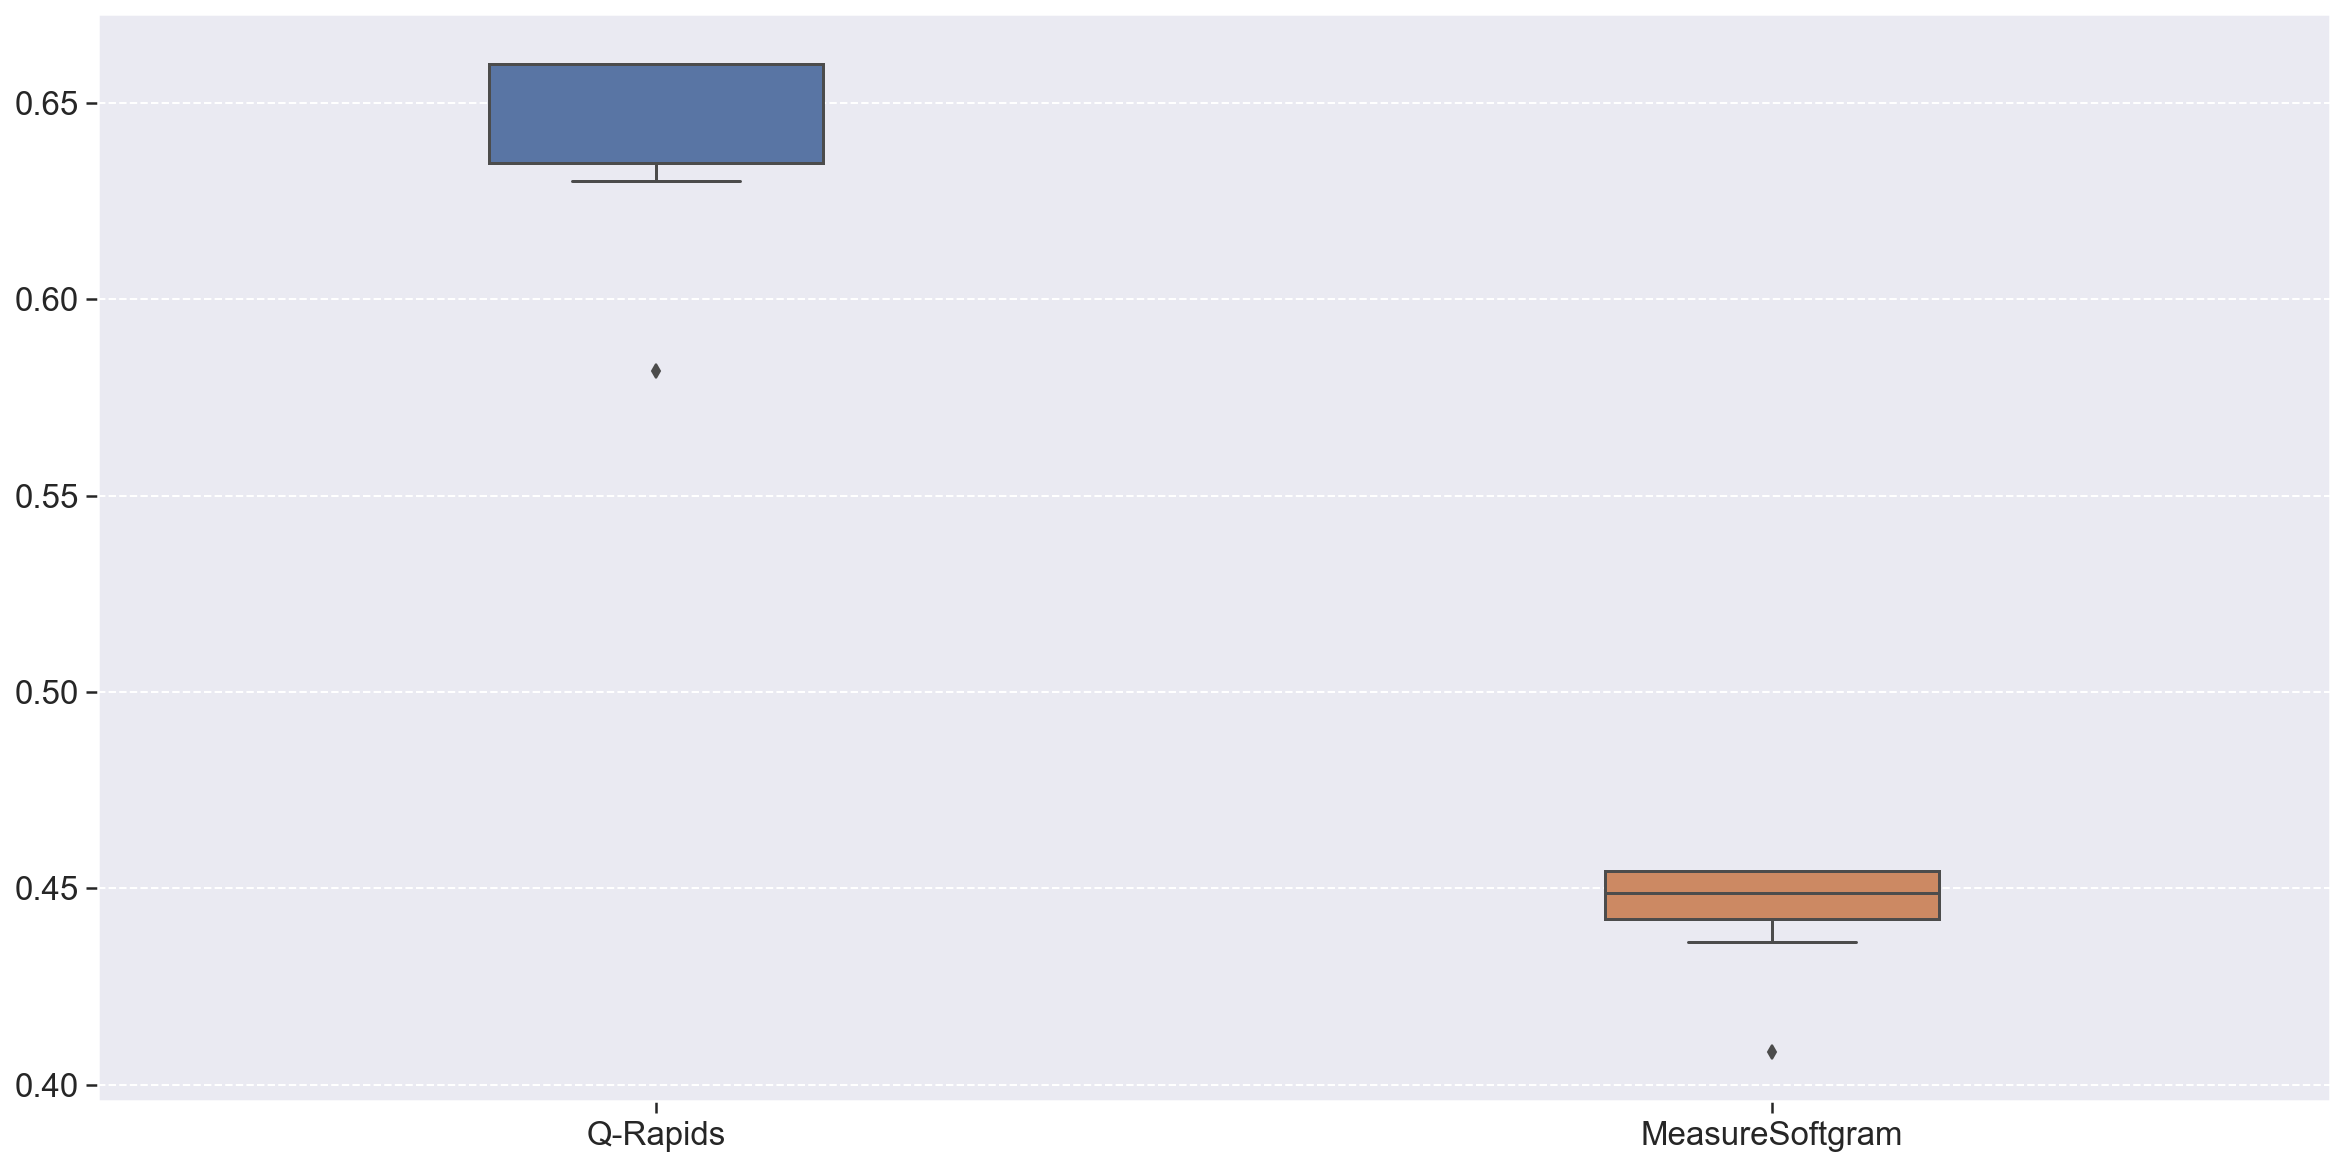

In [53]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(data=df, width=0.3)

plt.show()

# Scatter

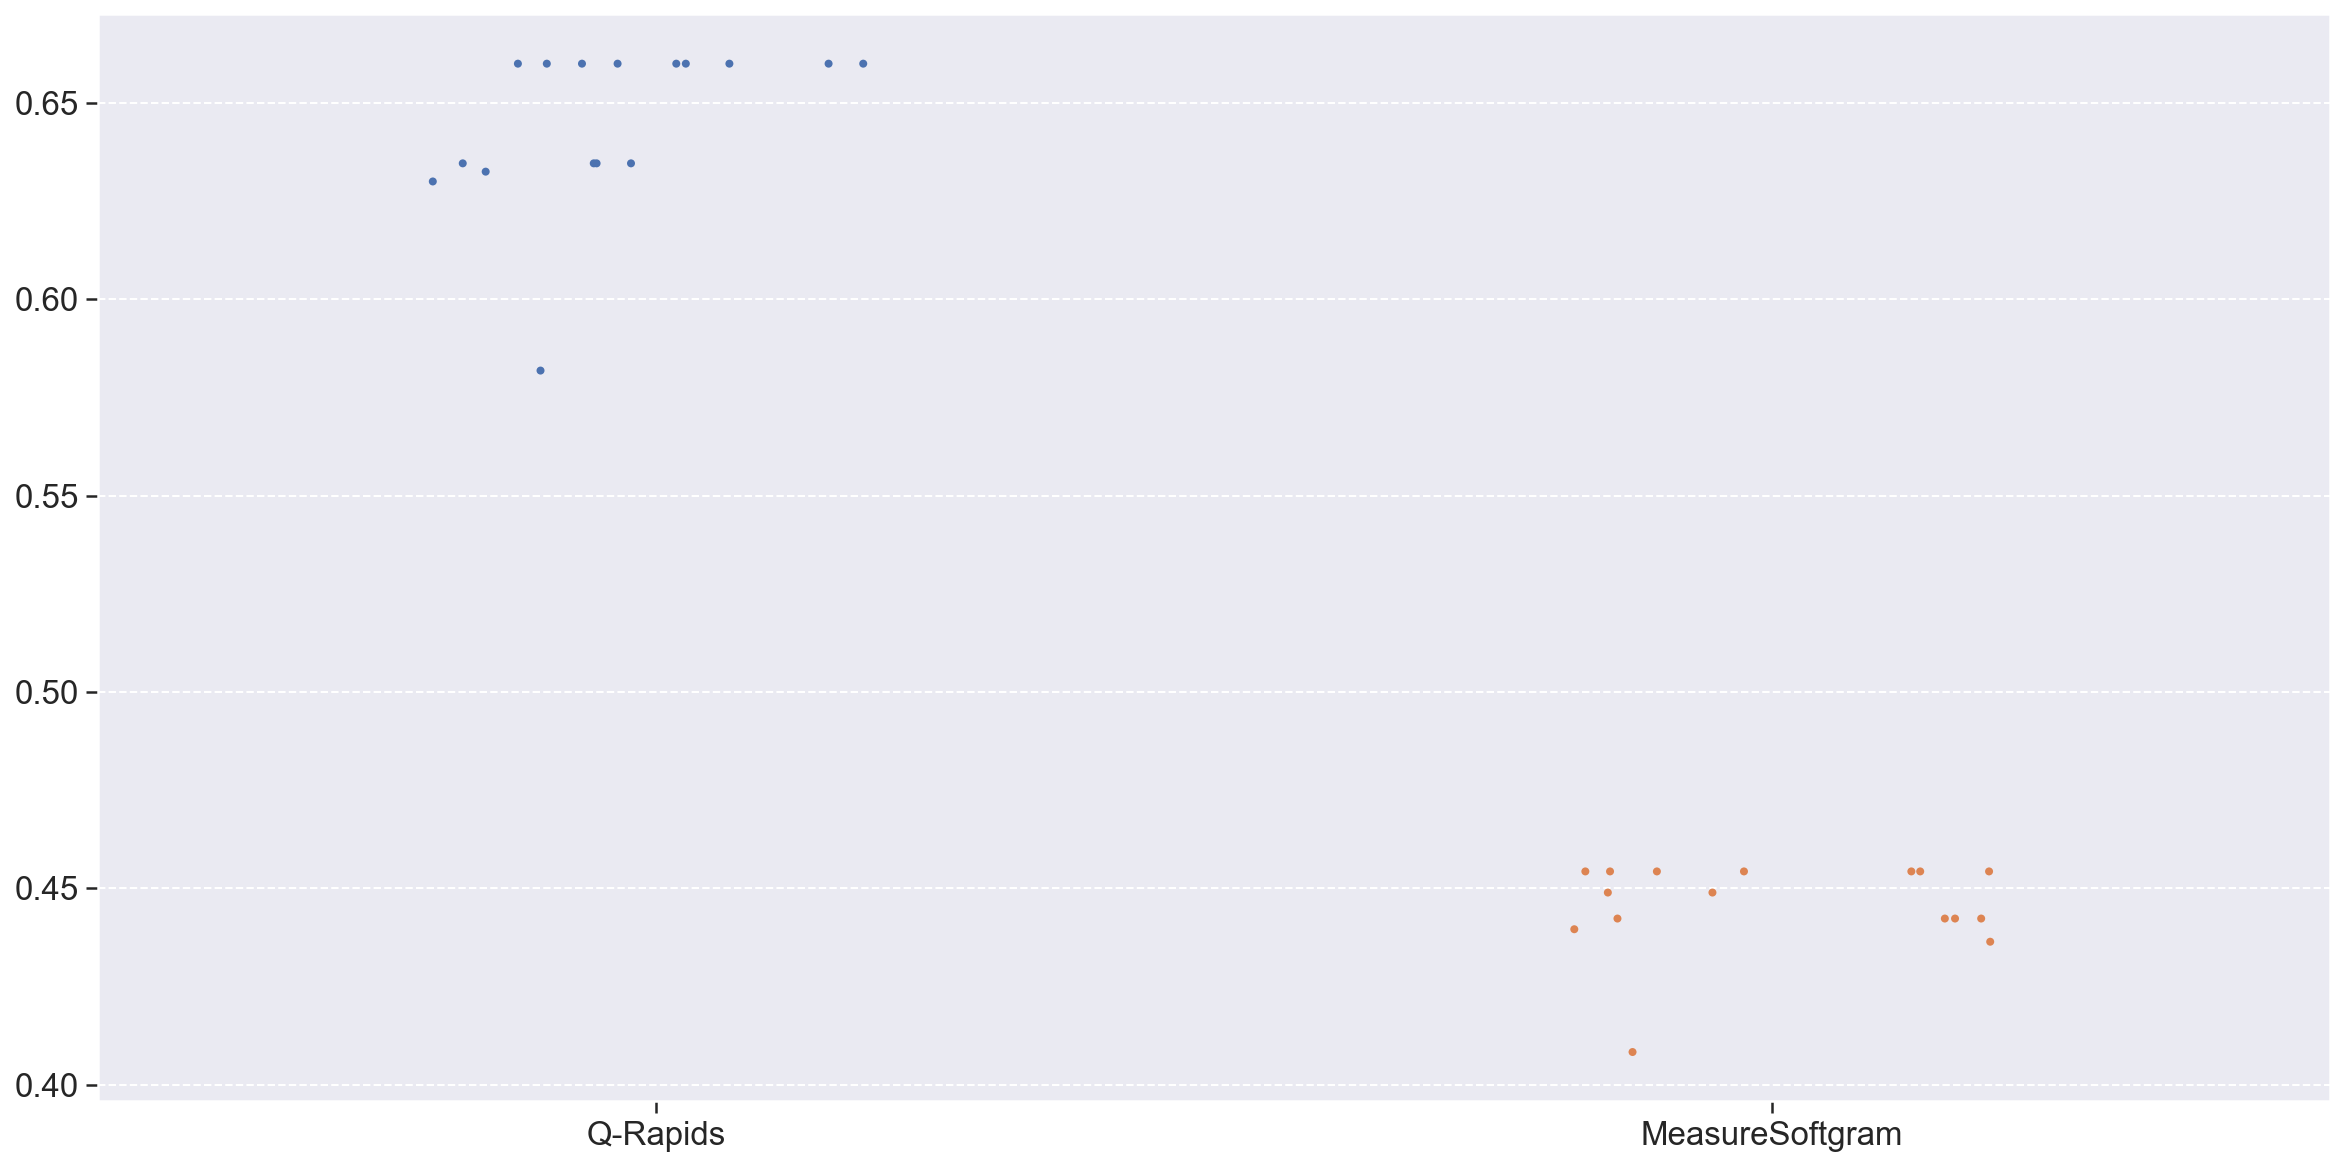

In [54]:
fig = plt.figure(figsize=(20, 10))
sns.stripplot(data=df, jitter=0.2, size=4)

plt.show()

# Hypothesis Test - **Effectiveness** - IEEE-Std-1061 Correlation Criteria - Square of the linear correlation coefficient (<em>R</em>).

#### <em>H</em><sub>1<sub>0</sub></sub>: if <em>R</em><sup>2</sup> is smaller than 0.8, it means that the variation observed in MeasureSoftGram is casual when compared with Q-Rapids.

#### <em>H</em><sub>1<sub>A</sub></sub>: if <em>R</em><sup>2</sup> is greater than 0.8, it means that at least 80% of the variation observed in MeasureSoftGram can be explained by the variation observed in Q-Rapids.

## <center> <em>H</em><sub>1<sub>0</sub></sub> : <em>R</em><sup>2</sup> <sub>(measuresoftgram_SQC, qrapids_TQ)</sub> < 0.8 </center>
## <center> <em>H</em><sub>1<sub>A</sub></sub> : <em>R</em><sup>2</sup> <sub>(measuresoftgram_SQC, qrapids_TQ)</sub> $\geq$ 0.8 </center>

In [55]:
print('**************** R-Squared *****************')

res = stats.linregress(np.ravel(dist_control), np.ravel(dist_predict))
print(f"R-squared: {res.rvalue**2:.6f}   p-value: {res.pvalue}")
print('********************************************' + '\n')

**************** R-Squared *****************
R-squared: 0.961409   p-value: 2.7165221756724042e-11
********************************************



# Hypothesis Test - **Efficiency** - IEEE-Std-1061 Tracking Criteria - Pearson correlation coefficient (<em>r</em>)

#### <em>H</em><sub>1<sub>0</sub></sub>: if <em>r</em><sup>2</sup> is smaller than 0 and close to -1, it means that the there is a high negative correlation between the two models.

#### <em>H</em><sub>1<sub>A</sub></sub>: if <em>r</em><sup>2</sup> is greater and equal than 0 and close to 1, it means that there is a high positive correlation between the two models.

## <center> <em>H</em><sub>1<sub>0</sub></sub> : <em>r</em><sup>2</sup> <sub>(measuresoftgram_SQC, qrapids_TQ)</sub> $\leq$ 0 </center>
## <center> <em>H</em><sub>1<sub>A</sub></sub> : <em>r</em><sup>2</sup> <sub>(measuresoftgram_SQC, qrapids_TQ)</sub> > 0 </center>

In [56]:
print('************ Person(r) test statistics *************')
r_stats, r_p_val = stats.pearsonr(np.ravel(dist_control), np.ravel(dist_predict))

print('Person(r) test statistics: '  + str(r_stats) + ' Person(r) test p-value: '  + str(r_p_val))
print('****************************************************' + '\n')



************ Person(r) test statistics *************
Person(r) test statistics: 0.9805145222692095 Person(r) test p-value: 2.7165221756723994e-11
****************************************************

